# Recency, Frequency, and Monetary Value Tables
See 'Notebooks/Data_Cleaning.ipynb' for data cleaning. Raw data imported from square.com was cleaned and some relevant features impacting the sales, such as weather and social media, were added.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
#importing cleaned data
sales_data = pd.read_csv('data/square/export/sales_data_clean.csv')
sales_data = sales_data.drop('Unnamed: 0', axis='columns')
sales_data['date'] = pd.to_datetime(sales_data['date'])

- Determine what customers are trackable – i.e. those that use a credit card to pay for their purchase. In the example here, the customer id for cash sales were grouped into the ID number of -1.

In [3]:
sales_data = sales_data[sales_data['customer_id_no'] != -1]

In [4]:
# Create the RFM table
NOW = dt.datetime(2023,5,1)

rfm_table = sales_data.groupby('customer_id_no').agg({'date': lambda x: (NOW - x.max()).days,
                                                      'visit_freq': lambda x: x.max(),
                                                      'gross_sales': lambda x: x.sum()})
rfm_table['date'] = rfm_table['date'].astype(int)
rfm_table.rename(columns={'date': 'recency', 
                         'visit_freq': 'frequency', 
                         'gross_sales': 'monetary_value'}, inplace=True)

In [5]:
# Creation of RFM groups
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [6]:
segmented_rfm = rfm_table


def RScore(x,p,d):
 if x <= d[p][0.25]:
     return 1
 elif x <= d[p][0.50]:
     return 2
 elif x <= d[p][0.75]:
     return 3
 else:
     return 4

def FMScore(x,p,d):
 if x <= d[p][0.25]:
     return 4
 elif x <= d[p][0.50]:
     return 3
 elif x <= d[p][0.75]:
     return 2
 else:
     return 1

# Adding quartile scores and computing the overall RFM Score
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, 
                                            args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore,
                                            args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore,
                                            args=('monetary_value',quantiles,))

segmented_rfm['RFMScore'] = (segmented_rfm.r_quartile.map(str) + 
                            segmented_rfm.f_quartile.map(str) +  
                            segmented_rfm.m_quartile.map(str))

segmented_rfm = segmented_rfm.reset_index()

In [29]:
average_recency = round(segmented_rfm['recency'].mean(),2)
average_frequency = round(segmented_rfm['frequency'].mean(),2)
average_expenditure = round(segmented_rfm['monetary_value'].mean(),2)

print("Average customer recency: {} days since last visit".format(average_recency), "\nAverage customer frequency: {} unique visits".format(average_frequency), "\nAverage customer spending: ${}".format(average_expenditure))

Average customer recency: 685.47 days since last visit 
Average customer frequency: 2.83 unique visits 
Average customer spending: $105.88


- It may be helpful to look at frequent customers who have not been visiting recently. Here it was filtered by at least 30 visits and spending more than $500 but not visiting in the last two months.

In [9]:
no_return = segmented_rfm.sort_values('monetary_value', ascending=False)
no_return = no_return[(no_return['recency'] > 60)&(no_return['monetary_value'] >= 500)&(no_return['frequency'] >= 30)]

## Visualization

In [10]:
custom_palette = sns.color_palette("Blues")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

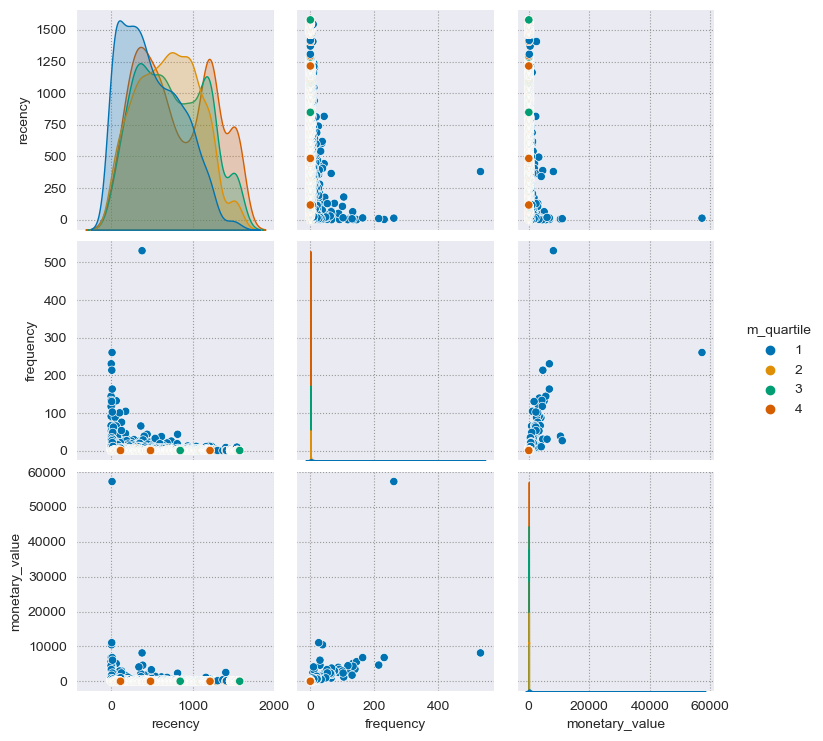

In [11]:
# Pairplot to visualize relationships between variables
sns.pairplot(segmented_rfm, vars=['recency','frequency','monetary_value'], palette = 'colorblind', hue='m_quartile')
plt.show()

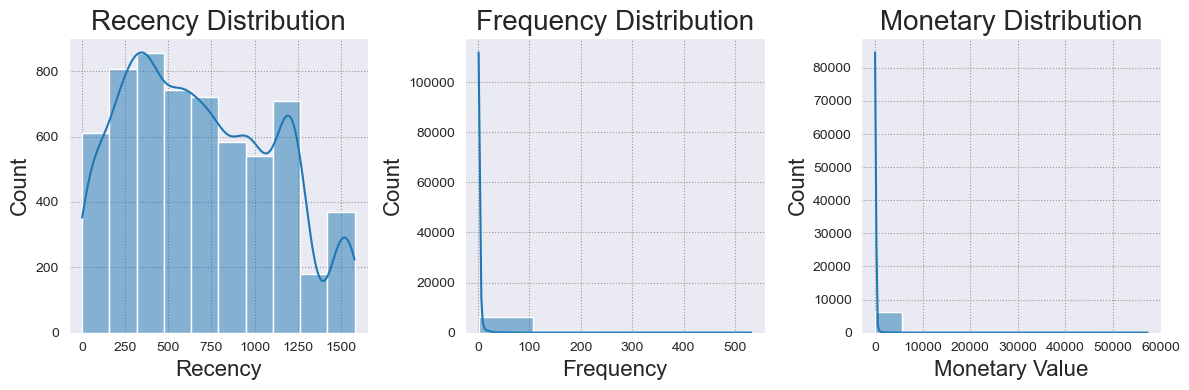

In [13]:
# Distribution plots for each RFM variable
plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.histplot(segmented_rfm['recency'], bins=10, kde=True)
plt.title('Recency Distribution', fontsize=20)
plt.xlabel('Recency', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.subplot(132)
sns.histplot(segmented_rfm['frequency'], bins=5, kde=True)
plt.title('Frequency Distribution', fontsize=20)
plt.xticks()
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.subplot(133)
sns.histplot(segmented_rfm['monetary_value'], bins=10, kde=True)
plt.title('Monetary Distribution', fontsize=20)
plt.xlabel('Monetary Value', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.tight_layout()
plt.show()

In [22]:
import plotly.express as px

def plotly_paired(key, value):
    rfm_list = ['r', 'f', 'm']
    axis_list = [key[0], value[0]]
    
    hue_id = list(set(rfm_list) - set(axis_list))
    scored = str(hue_id[0]) + '_quartile'
    
    x_label = label_dict[key]
    print(x_label)
    fig = px.scatter(segmented_rfm, x=key, y=value, color=scored, labels={'x': key.capitalize(), 'y': value.capitalize()}, hover_name = 'customer_id_no')
    
    fig.update_layout(
        title=f"{key.capitalize()} v {value.capitalize()}",
        xaxis_title=key.capitalize(),
        yaxis_title=value.capitalize(),
        font=dict(size=16)
    )
    
    fig.show()


Days since last visit


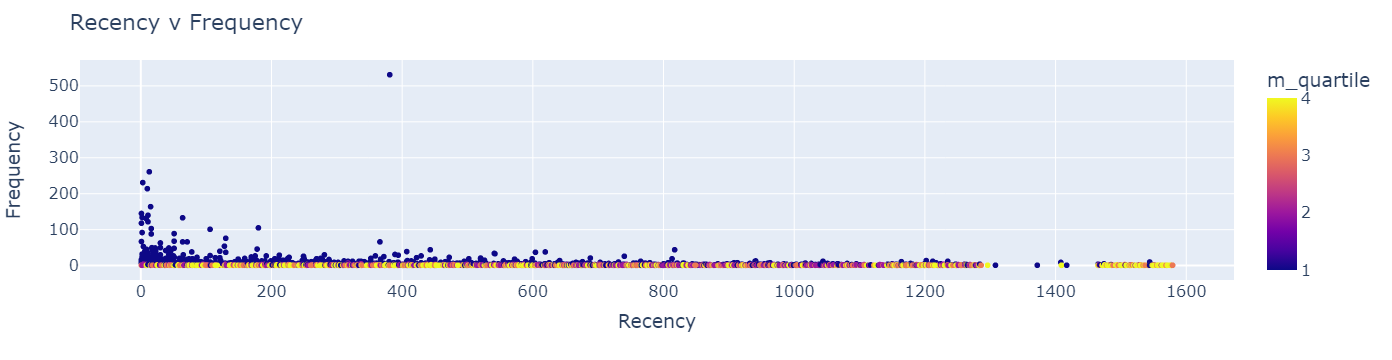

In [21]:
plotly_paired('recency', 'frequency')

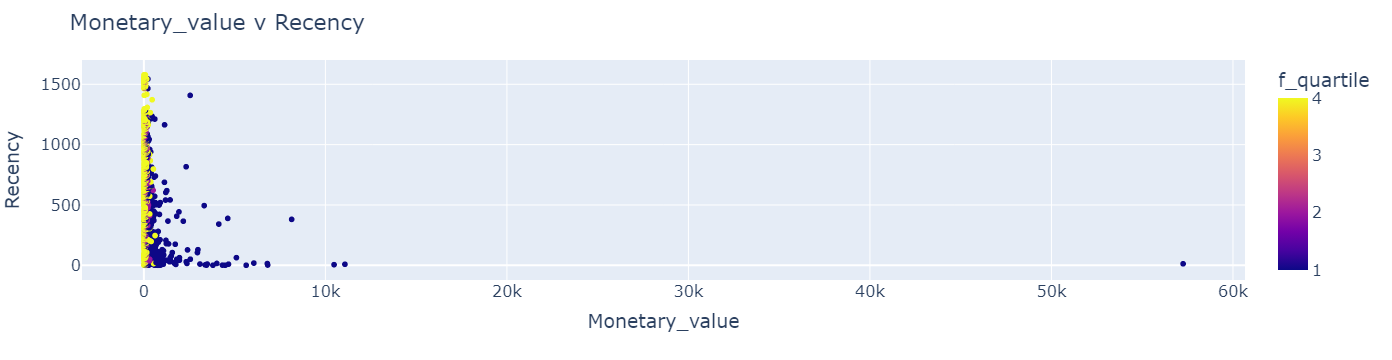

In [16]:
plotly_paired('monetary_value', 'recency')

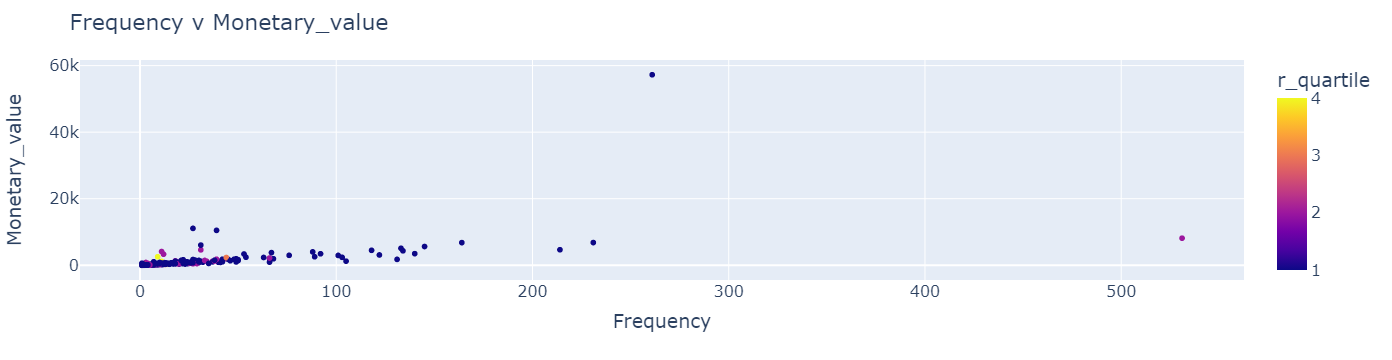

In [17]:
plotly_paired('frequency', 'monetary_value')